# Projeto Transefer_Learning

🐱🐶 Transfer Learning com Cats vs Dogs


In [ ]:
# NO VSCODE : pip install tensorflow tensorflow-datasets

In [ ]:
#no terminal do jupyter notebook
! pip install -q tensorflow-datasets
! pip install -q tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


Classes: ['cat', 'dog']
Informações do dataset: tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorizat

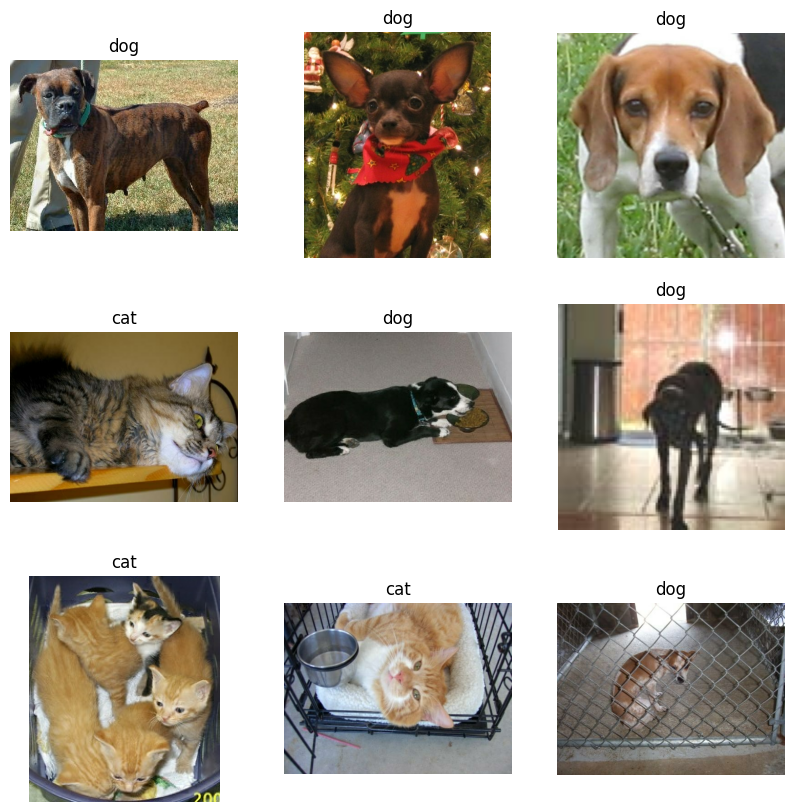

In [ ]:
# 1️⃣ Carregar o Dataset
(train_data, val_data, test_data), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)
class_names = info.features['label'].names
print("Classes:", class_names)
print("Informações do dataset:", info)

# Visualizar algumas imagens
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_data.take(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')
plt.show()


In [ ]:
# 2️⃣ Pré-processamento e Aumento de Dados
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = data_augmentation(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image) #Codigo para mais de 2 labels(Gato_Cachorro_......etc).
    return image, label

train_data = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
# 3️⃣ Construir o Modelo com Transfer Learning
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# 4️⃣ Treinar o Modelo com EarlyStopping(Parada Antecipada)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=2,
    callbacks=[early_stop]
)


Epoch 1/2
582/582 ━━━━━━━━━━━━━━━━━━━━ 224s 385ms/step - accuracy: 0.9765 - loss: 0.0597 - val_accuracy: 0.9811 - val_loss: 0.0544
Epoch 2/2
508/582 ━━━━━━━━━━━━━━━━━━━━ 25s 343ms/step - accuracy: 0.9817 - loss: 0.0525

In [ ]:
# 5️⃣ Avaliar o Modelo
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc * 100:.2f}%")


73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 326ms/step - accuracy: 0.9826 - loss: 0.0526
Test accuracy: 97.94%


In [ ]:
# 6️⃣ Ajuste Fino (Fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=2,
    callbacks=[early_stop]
)


Epoch 1/2
582/582 ━━━━━━━━━━━━━━━━━━━━ 260s 413ms/step - accuracy: 0.8846 - loss: 0.2818 - val_accuracy: 0.9776 - val_loss: 0.0566
Epoch 2/2
582/582 ━━━━━━━━━━━━━━━━━━━━ 226s 388ms/step - accuracy: 0.9716 - loss: 0.0781 - val_accuracy: 0.9798 - val_loss: 0.0518


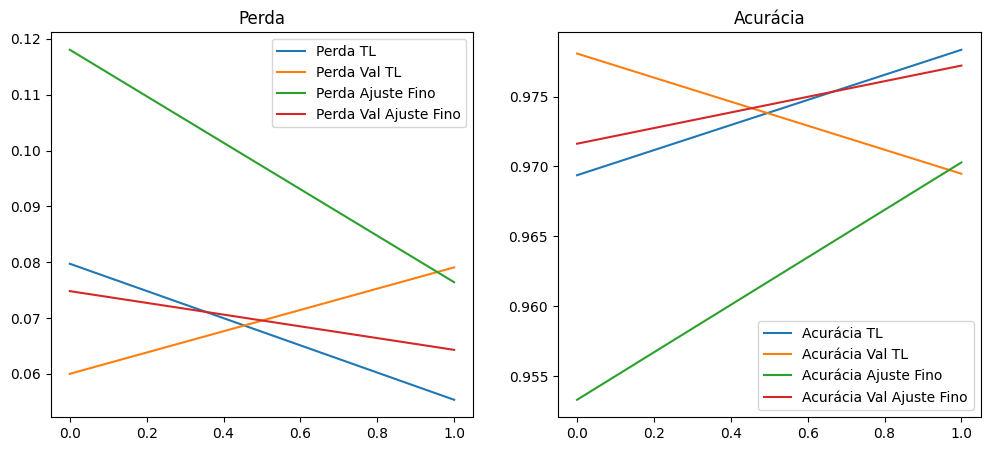

In [ ]:
# 7️⃣ Visualizar curvas de treinamento
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Perda TL')
plt.plot(history.history['val_loss'], label='Perda Val TL')
plt.plot(history_finetune.history['loss'], label='Perda Ajuste Fino')
plt.plot(history_finetune.history['val_loss'], label='Perda Val Ajuste Fino')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Acurácia TL')
plt.plot(history.history['val_accuracy'], label='Acurácia Val TL')
plt.plot(history_finetune.history['accuracy'], label='Acurácia Ajuste Fino')
plt.plot(history_finetune.history['val_accuracy'], label='Acurácia Val Ajuste Fino')
plt.title('Acurácia')
plt.legend()
plt.show()

In [ ]:
# Obter previsões do modelo
y_true = []
y_pred = []
for images, labels in test_data:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1).numpy() # Obtenha o índice de maior probabilidade e converta em uma matriz numpy
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend(preds.astype(int)) # Garanta que as previsões sejam números inteiros

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


Matriz de Confusão:


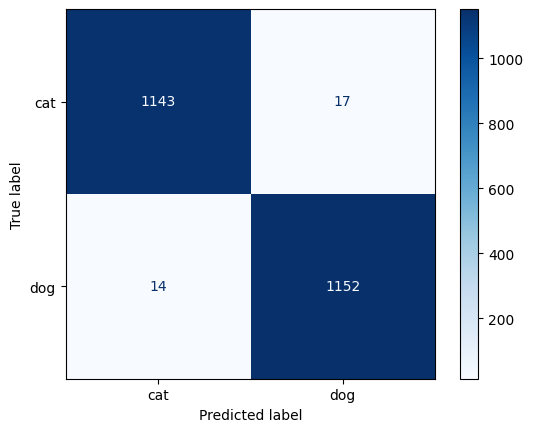

[[1143   17]
 [  14 1152]]
Relatório de Classificação:
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      1160
         Dog       0.99      0.99      0.99      1166

    accuracy                           0.99      2326
   macro avg       0.99      0.99      0.99      2326
weighted avg       0.99      0.99      0.99      2326



In [ ]:
# Matriz de confusão
print("Matriz de Confusão:")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(cm)

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

- A matriz de confusão mostra um resumo do desempenho do modelo no conjunto de teste. Ela compara as classes verdadeiras (True Label) com as classes que o modelo previu (Predicted Label).

- True Positives (TP): No canto superior esquerdo, temos 1143. Isso significa que o modelo previu corretamente que 1143 imagens eram de gatos (Cat) e elas realmente eram gatos.
- True Negatives (TN): No canto inferior direito, temos 1152. Isso significa que o modelo previu corretamente que 1152 imagens eram de cachorros (Dog) e elas realmente eram cachorros.
- False Positives (FP): No canto superior direito, temos 17. Isso significa que o modelo previu que 17 imagens eram de cachorros (Dog), mas na verdade eram gatos (Cat). Estes são erros do Tipo I.
- False Negatives (FN): No canto inferior esquerdo, temos 14. Isso significa que o modelo previu que 14 imagens eram de gatos (Cat), mas na verdade eram cachorros (Dog). Estes são erros do Tipo II.

- Precision (Precisão): Para a classe 'Cat', a precisão é 0.99. Isso significa que, das vezes que o modelo previu que uma imagem era um gato, 99% delas realmente eram gatos. 
- Para 'Dog', a precisão também é 0.99.
- Recall (Revocação ou Sensibilidade): Para a classe 'Cat', o recall é 0.99. - Isso significa que o modelo identificou corretamente 99% de todos os gatos no conjunto de teste. Para 'Dog', o recall também é 0.99.
- F1-score: É a média harmônica da precisão e do recall. Um F1-score alto indica que o modelo tem boa precisão e recall. Para ambas as classes, o F1-score é 0.99, o que é excelente.
- Support (Suporte): É o número de ocorrências reais da classe no conjunto de teste. Temos 1160 imagens de gatos e 1166 imagens de cachorros no conjunto de teste.
- Accuracy (Acurácia): A acurácia geral do modelo é 0.99. Isso significa que o modelo classificou corretamente 99% das imagens no conjunto de teste.

### Com base na matriz de confusão e no relatório de classificação, o modelo apresenta um desempenho muito bom na tarefa de classificar imagens de gatos e cachorros no conjunto de teste. As métricas de precisão, recall e F1-score são altas para ambas as classes, e a acurácia geral é de 99%. Isso indica que o modelo comete poucos erros de classificação.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


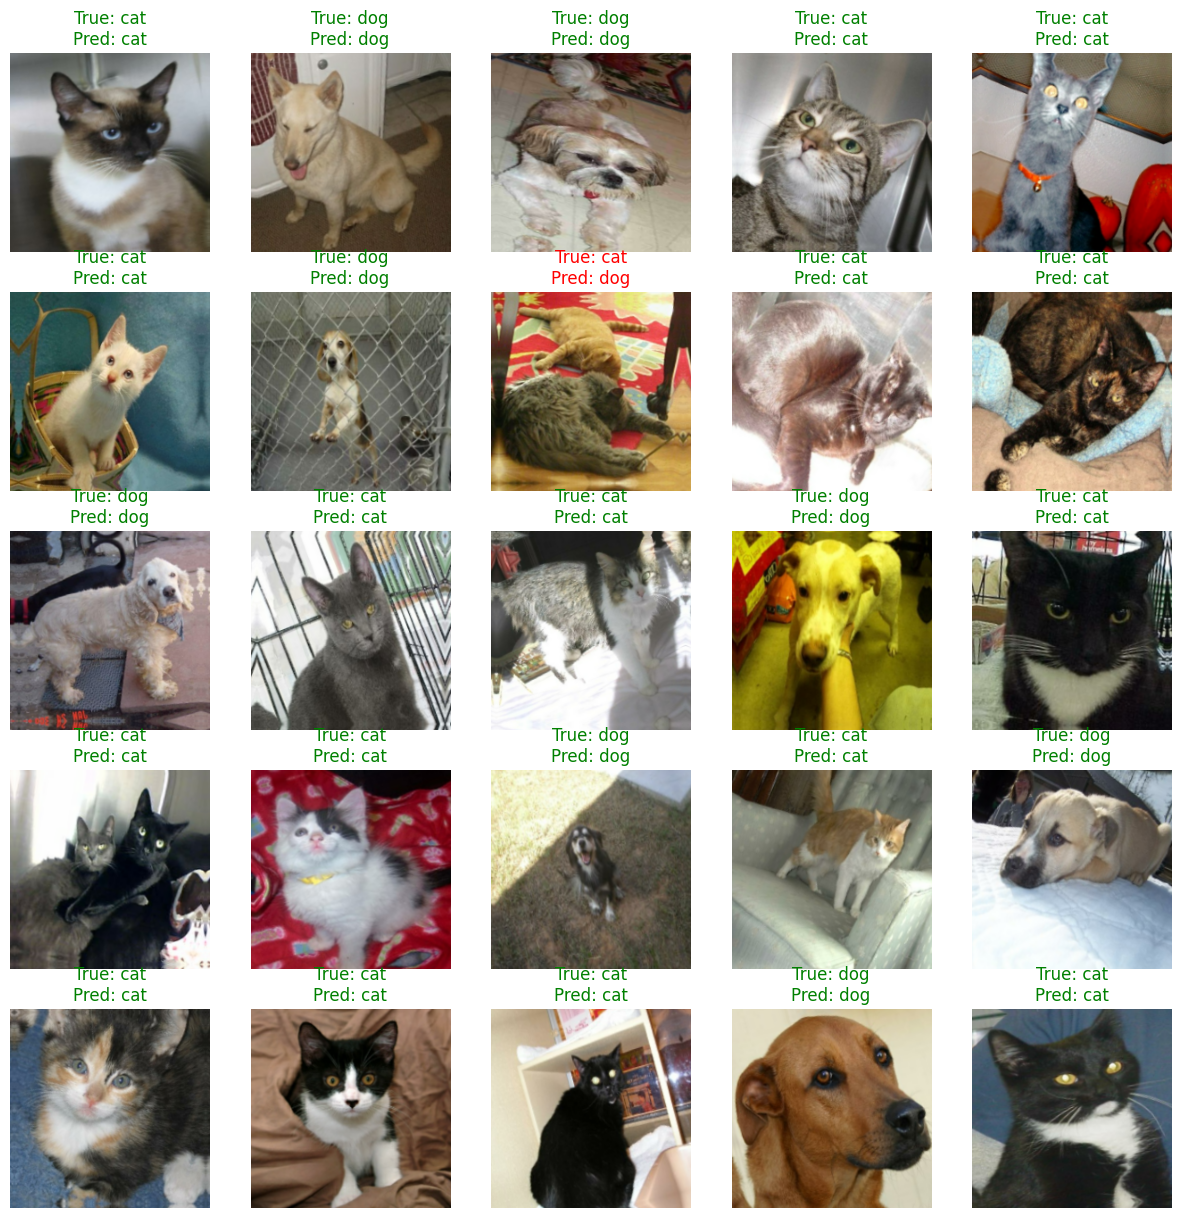

In [ ]:
# Obtenha algumas imagens e rótulos do conjunto de dados de testetest_images = []
test_labels = []
for images, labels in test_data.take(5): # Pegue os primeiros 5 lotes
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

# Faça previsões sobre essas imagens
predictions = model.predict(np.array(test_images))
predicted_labels = np.argmax(predictions, axis=1)

# Visualize algumas imagens com suas previsões
plt.figure(figsize=(15, 15))
for i in range(25): # Exibir até 25 imagens
    if i < len(test_images):
        plt.subplot(5, 5, i + 1)
    # Desnormalizar a imagem para exibição
        display_image = test_images[i]
        display_image = (display_image * 127.5 + 127.5).astype(np.uint8)

        plt.imshow(display_image)
        color = "green" if predicted_labels[i] == test_labels[i] else "red"
        plt.title(f"True: {class_names[test_labels[i]]}\nPred: {class_names[predicted_labels[i]]}", color=color)
        plt.axis("off")
plt.show()

## 8️⃣ Salvar e Carregar o Modelo

Para salvar o modelo treinado, você pode usar o método `save`:

In [ ]:
# Salvar o modelo treinado
model_save_path = "cats_vs_dogs_model.h5"
model.save(model_save_path)
print(f"Modelo salvo em: {model_save_path}")

Modelo salvo em: cats_vs_dogs_model.h5


Para carregar o modelo salvo e usá-lo para fazer previsões em novas imagens:

In [ ]:
# Carregar o modelo salvo
loaded_model = tf.keras.models.load_model(model_save_path)
print("Modelo carregado com sucesso.")